In [1]:
'''PACKAGE IMPORTS'''
#For data analysis
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from matplotlib.gridspec import GridSpec
import numpy as np
import seaborn as sns
import scipy
import xarray as xr
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime as dt

from scipy.signal import find_peaks
from scipy.stats import kendalltau

from functions import *

## Imports

In [2]:
'''Import Data Links'''
import_path = "./Cleaned Data/"
import_path_raw = "./Raw Data/"

In [3]:
'''Import Data'''
### Import Snow Data
s2data = xr.open_dataset(import_path + '01_cleanedsnowdataS2.nc')
s2data_df = s2data.to_dataframe().reset_index(drop = False)
s2data_df = s2data_df.replace('NaN', np.nan)
s2data_df = s2data_df.replace('nan', np.nan)
s2data_df.time = pd.to_datetime(s2data_df.time)
s2data_df['watershed'] = 'S2'

s6data = xr.open_dataset(import_path + '01_cleanedsnowdataS6.nc')
s6data_df = s6data.to_dataframe().reset_index(drop = False)
s6data_df = s6data_df.replace('NaN', np.nan)
s6data_df = s6data_df.replace('nan', np.nan)
s6data_df.time = pd.to_datetime(s6data_df.time)
s6data_df['watershed'] = 'S6'

allSnow_df = pd.concat([s6data_df, s2data_df]).reset_index()

#Precipitation data - update from MN DNR site occasionally, eventually replace with MEF data
precip = pd.read_csv(import_path_raw + 'GrandRapids_Precip_MNDNR.csv', 
                     na_values = ['T', 'M'], 
                     parse_dates = ['Date'], 
                     names = ['Date', 'Tmax_F', 'Tmin_F', 'P_in', 'Snow_in', 'SnowDepth_in'], 
                     header = 0, 
                     dtype = {'P_in':float, 'Snow_in':float, 'SnowDepth_in':float})
precip = precip[precip.Date > '2022-10-01'].reset_index(drop = True)

### Import LAI Data
s2LAI = pd.read_csv(import_path + "S2_winterLAI_calibrated.csv")
s6LAI = pd.read_csv(import_path + "S6_winterLAI_calibrated.csv")
lai_df = pd.concat([s2LAI, s6LAI]).reset_index()

### Import Weekly Met Data
weeklyMet = pd.read_csv(import_path + "/ATM/WeeklyATMSummary.csv")

# Import SWE data
SWE = pd.read_csv(import_path + "2023SWE_data.csv", 
                parse_dates = ['DATE'])

Text(0.5, 1.0, 'Snow Accumulation from Grand Rapids Forestry Research Station')

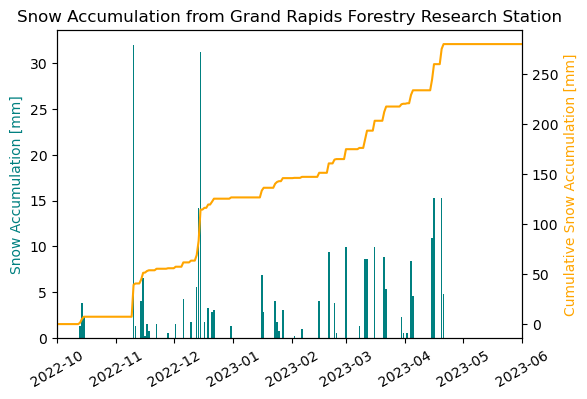

In [4]:
'''Open Canopy Snow_mm from GR'''
precip['Snow_mm'] = 25.4*(np.where(precip.Snow_in > 0.0, precip.P_in, 0)) #Convert in to mm

fig, ax = plt.subplots(1, 1, figsize = (6,4))
#Snow Inputs
ax.bar(precip.Date, precip.Snow_mm, color = 'teal')
#Season Accumulation
ax2 = plt.twinx(ax)
ax2.plot(precip.Date, np.cumsum(precip.Snow_mm), color = 'orange')
plt.xlim('2022-10-01','2023-06-01')
plt.xlabel('Date')
ax.set_ylabel('Snow Accumulation [mm]', color = 'teal')
ax2.set_ylabel('Cumulative Snow Accumulation [mm]', color = 'orange')
ax.tick_params(axis='x', rotation=30)
ax.set_title('Snow Accumulation from Grand Rapids Forestry Research Station')

## Snow Model

### Model Calculations

In [5]:
'''Calculate Under Canopy Accumulation Rates'''
stakes = ['S236', 'S213', 'S632', 'S200', 'S623', 'S211', 'S633', 'S235',
          'S644', 'S646', 'S202', 'S201', 'S204', 'S631', 'S645', 'S212',
          'S221', 'S635', 'S621', 'S232', 'S222', 'S223', 'S624', 'S625',
          'S655', 'S205', 'S246', 'S643', 'S225', 'S203', 'S622', 'S255',
          'S654', 'S636', 'S224', 'S603', 'S612', 'S254', 'S642', 'S233',
          'S215', 'S613', 'S245', 'S614', 'S234', 'S634', 'S220', 'S243',
          'S611', 'S226', 'S244']

modelledSnow = pd.DataFrame()

#Calculate Snow in under the canopy
for stake in stakes:
    temp = modelSWE(stake, lai_df, allSnow_df, precip)
    
    #concat
    modelledSnow = pd.concat([modelledSnow, temp])

modelledSnow

,index,time,northing,easting,depths,zones,stakes,aspect,slope,watershed,...,LAI,CanopyDensity,Snow_mm_underCanopy,Interception_mm,DDF,Melt_cm_potential,Snow_cm_underCanopy,deltaSWE,SWE_cm,Melt_cm_modelled
0,NaN,NaT,464596.4,5262552.0,NaN,Upland,S236,4.635716,1.32895,S2,...,0.206218,0.093141,0.0,0.0,0.276725,4.150873,0.0,-4.150873,0.0,0.0
1,NaN,NaT,464596.4,5262552.0,NaN,Upland,S236,4.635716,1.32895,S2,...,0.206218,0.093141,0.0,0.0,0.276725,4.688949,0.0,-4.688949,0.0,0.0
2,NaN,NaT,464596.4,5262552.0,NaN,Upland,S236,4.635716,1.32895,S2,...,0.206218,0.093141,0.0,0.0,0.276725,4.765817,0.0,-4.765817,0.0,0.0
3,NaN,NaT,464596.4,5262552.0,NaN,Upland,S236,4.635716,1.32895,S2,...,0.206218,0.093141,0.0,0.0,0.276725,4.535213,0.0,-4.535213,0.0,0.0
4,NaN,NaT,464596.4,5262552.0,NaN,Upland,S236,4.635716,1.32895,S2,...,0.206218,0.093141,0.0,0.0,0.276725,1.306756,0.0,-1.306756,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,NaN,NaT,464522.2,5262448.0,NaN,Upland,S244,355.678900,8.02736,S2,...,0.296030,0.197984,0.0,0.0,0.259531,6.632449,0.0,-6.632449,0.0,0.0
299,NaN,NaT,464522.2,5262448.0,NaN,Upland,S244,355.678900,8.02736,S2,...,0.296030,0.197984,0.0,0.0,0.259531,5.839438,0.0,-5.839438,0.0,0.0
300,NaN,NaT,464522.2,5262448.0,NaN,Upland,S244,355.678900,8.02736,S2,...,0.296030,0.197984,0.0,0.0,0.259531,4.830153,0.0,-4.830153,0.0,0.0
301,NaN,NaT,464522.2,5262448.0,NaN,Upland,S244,355.678900,8.02736,S2,...,0.296030,0.197984,0.0,0.0,0.259531,4.613877,0.0,-4.613877,0.0,0.0


### Melt Calculations

In [6]:
'''Estimate Melt and Melt season from Measured SWE'''
SWE['Melt_cm'] = SWE.groupby('SITE')['SWE_cm'].diff().fillna(0)
SWE['Melt_cm'] = np.where(SWE.Melt_cm < 0, -SWE.Melt_cm, 0)

#Assign accumulation/melt season label
SWE['maxSWE_index'] = SWE.groupby('SITE')['SWE_cm'].transform('idxmax')
SWE['maxDATE'] = [SWE['DATE'][i] for i in SWE['maxSWE_index']]
SWE['Season'] = np.where(SWE.DATE < SWE.maxDATE, 'Accumulation', 'Melt')

SWE

,SITE,DATE,SWE_cm,Melt_cm,maxSWE_index,maxDATE,Season
0,S220,2023-01-13,3.556,0.0,349,2023-03-17,Accumulation
1,S215,2023-01-13,7.620,0.0,404,2023-03-24,Accumulation
2,S205,2023-01-13,5.080,0.0,405,2023-03-24,Accumulation
3,S204,2023-01-13,0.254,0.0,352,2023-03-17,Accumulation
4,S203,2023-01-13,8.128,0.0,461,2023-03-31,Accumulation
...,...,...,...,...,...,...,...
614,S621,2023-04-27,NaN,0.0,506,2023-03-31,Melt
615,S611,2023-04-27,NaN,0.0,345,2023-03-09,Melt
616,S612,2023-04-27,4.826,0.0,508,2023-03-31,Melt
617,S623,2023-04-27,11.430,0.0,455,2023-03-24,Melt


### Model Plots

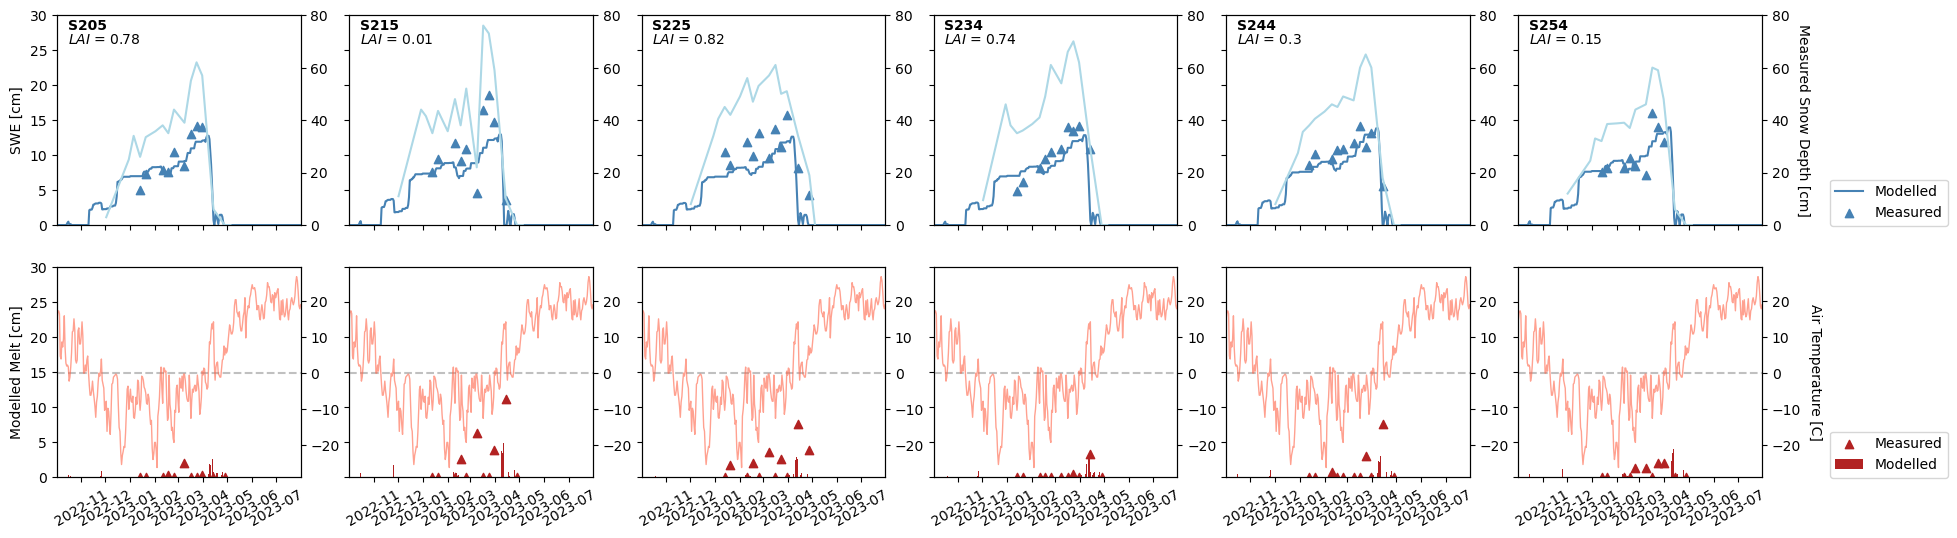

In [7]:
fig, axs = plt.subplots(2, 6, figsize = (22,6), 
                        sharex = True, 
                        sharey = True)

stakes = ['S205', 'S215', 'S225', 'S234', 'S244', 'S254']
for i in range(0, len(stakes)):
    stake = stakes[i]

    datasubset = modelledSnow[modelledSnow.stakes == stake].reset_index(drop = True)
    SWEsubset = SWE[SWE.SITE == stake]
    
    #Top row is SWE[ax1], snow depth[ax2], and interception[ax1]
    axs[0, i].plot(datasubset.Date, datasubset.SWE_cm, label = 'Modelled', color = 'steelblue')
    axs[0, i].scatter(SWEsubset.DATE, SWEsubset.SWE_cm, label = 'Measured', color = 'steelblue', marker = '^')
    axs[0, i].set_ylim(0, 30)
   
    axs_twin = plt.twinx(axs[0, i])
    sns.lineplot(data = datasubset, x = 'Date', y = 'depths', color = 'lightblue', ax = axs_twin)
    axs_twin.set_ylim(0, 80)

    #Bottom row is air temp[ax2] and melt[ax1]
    axs[1, i].bar(datasubset.Date, datasubset.Melt_cm_modelled, color = 'firebrick', label = 'Modelled')
    axs[1, i].scatter(SWEsubset.DATE, SWEsubset.Melt_cm, color = 'firebrick', marker = '^', label = 'Measured')

    axs1_twin = plt.twinx(axs[1, i])
    axs1_twin.hlines(0, min(modelledSnow.Date), max(modelledSnow.Date), color = 'silver', linestyle = '--')
    axs1_twin.plot(datasubset.Date, datasubset.Tavg_C, color = 'tomato', alpha = 0.6, linewidth = 1)

    #Plot settings
    plt.xlim(min(modelledSnow.Date), max(modelledSnow.Date))
    axs[1, i].tick_params(axis='x', rotation=30)

    if(i == 0):
        axs[0, i].set_ylabel('SWE [cm]')
        axs[1, i].set_ylabel('Modelled Melt [cm]')
        axs_twin.set_ylabel(' ')

    elif(i == 5):
        axs_twin.set_ylabel('Measured Snow Depth [cm]', rotation = 270, labelpad = 15)
        axs1_twin.set_ylabel('Air Temperature [C]', rotation = 270, labelpad = 15)
        axs[0, i].legend(bbox_to_anchor=(1.25, 0.25))
        axs[1, i].legend(bbox_to_anchor=(1.25, 0.25))

    else:
        axs_twin.set_ylabel(' ')

    #Plot text
    axs[0, i].text('2022-10-15', 28, stake, fontweight = 'bold')
    axs[0, i].text('2022-10-15', 26, '$LAI$ = ' + str(np.round(datasubset.LAI[0], 2)))


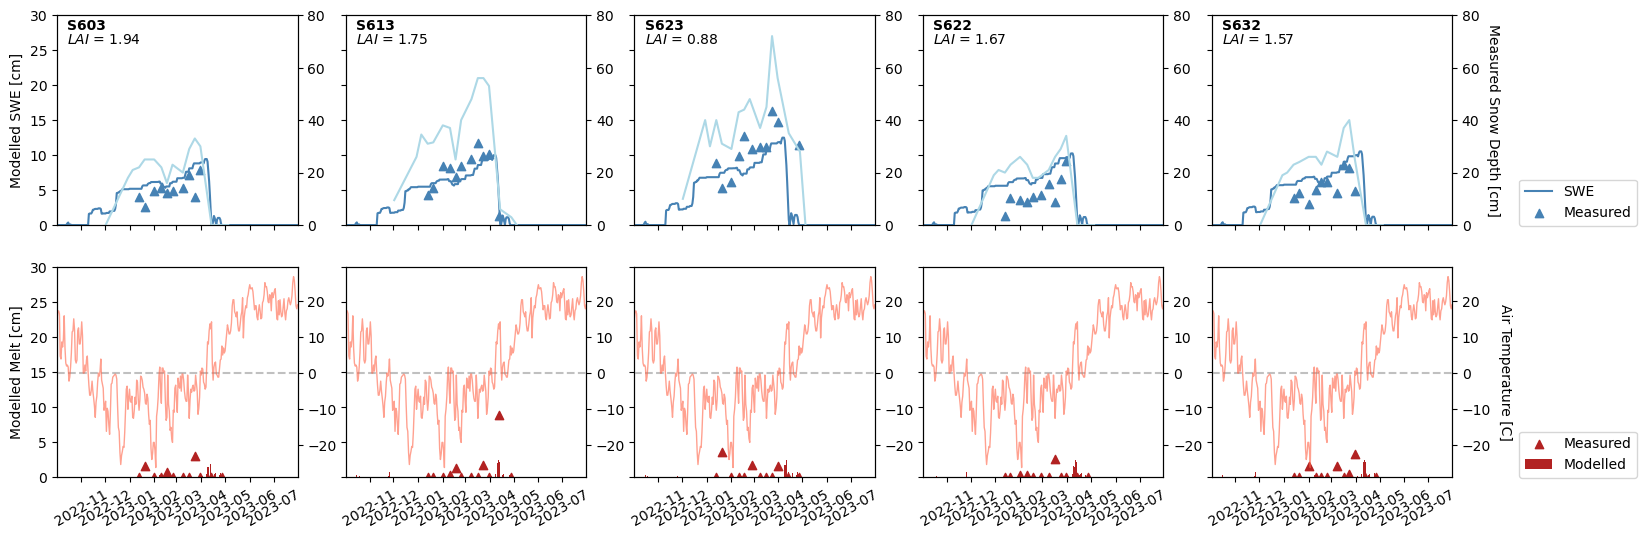

In [8]:
fig, axs = plt.subplots(2, 5, figsize = (18,6), 
                        sharex = True, 
                        sharey = True)

stakes = ['S603', 'S613', 'S623', 'S622', 'S632']
for i in range(0, len(stakes)):
    stake = stakes[i]

    datasubset = modelledSnow[modelledSnow.stakes == stake].reset_index(drop = True)
    SWEsubset = SWE[SWE.SITE == stake]
    
    #Top row is SWE[ax1], snow depth[ax2], and interception[ax1]
    axs[0, i].plot(datasubset.Date, datasubset.SWE_cm, label = 'SWE', color = 'steelblue')
    axs[0, i].scatter(SWEsubset.DATE, SWEsubset.SWE_cm, label = 'Measured', color = 'steelblue', marker = '^')
    axs[0, i].set_ylim(0, 30)
    
    axs_twin = plt.twinx(axs[0, i])
    sns.lineplot(data = datasubset, x = 'Date', y = 'depths', color = 'lightblue', ax = axs_twin)
    axs_twin.set_ylim(0, 80)

    #Bottom row is air temp[ax2] and melt[ax1]
    axs[1, i].bar(datasubset.Date, datasubset.Melt_cm_modelled, color = 'firebrick', label = 'Modelled')
    axs[1, i].scatter(SWEsubset.DATE, SWEsubset.Melt_cm, color = 'firebrick', marker = '^', label = 'Measured')

    axs1_twin = plt.twinx(axs[1, i])
    axs1_twin.hlines(0, min(modelledSnow.Date), max(modelledSnow.Date), color = 'silver', linestyle = '--')
    axs1_twin.plot(datasubset.Date, datasubset.Tavg_C, color = 'tomato', alpha = 0.6, linewidth = 1)

    #Plot settings
    plt.xlim(min(modelledSnow.Date), max(modelledSnow.Date))
    axs[1, i].tick_params(axis='x', rotation=30)

    if(i == 0):
        axs[0, i].set_ylabel('Modelled SWE [cm]')
        axs[1, i].set_ylabel('Modelled Melt [cm]')
        axs_twin.set_ylabel(' ')
    elif(i == 4):
        axs_twin.set_ylabel('Measured Snow Depth [cm]', rotation = 270, labelpad = 15)
        axs1_twin.set_ylabel('Air Temperature [C]', rotation = 270, labelpad = 15)
        axs[0, i].legend(bbox_to_anchor=(1.25, 0.25))
        axs[1, i].legend(bbox_to_anchor=(1.25, 0.25))
    else:
        axs_twin.set_ylabel(' ')

    #Plot text
    axs[0, i].text('2022-10-15', 28, stake, fontweight = 'bold')
    axs[0, i].text('2022-10-15', 26, '$LAI$ = ' + str(np.round(datasubset.LAI[0], 2)))


### Model Error Analysis

In [9]:
#Merge in measrued SWE data
modelledSnow_SWE = modelledSnow.merge(SWE, right_on = ['DATE', 'SITE'], left_on = ['Date', 'stakes'], how = 'outer')
modelledSnow_SWE = modelledSnow_SWE.rename(columns = {'SWE_cm_x' : 'SWE_cm_modelled', 
                         'SWE_cm_y' : 'SWE_cm_measured', 
                         'Melt_cm' : 'Melt_cm_measured'})

c:\Users\marie\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Model - Measured SWE')

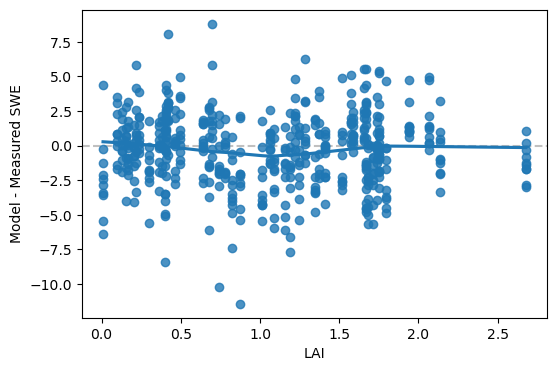

In [10]:
'''Model Error Analysis'''
fig, ax = plt.subplots(1, 1, figsize = (6,4))

ax.axhline(y = 0, xmin = 0, xmax = 2.5, linestyle = '--', color = 'silver', zorder = -2)
modelledSnow_SWE['modelError'] = modelledSnow_SWE.SWE_cm_modelled - modelledSnow_SWE.SWE_cm_measured
sns.regplot(modelledSnow_SWE.LAI, modelledSnow_SWE.modelError, 
            lowess = True, ax = ax)
ax.set_xlabel('LAI')
ax.set_ylabel('Model - Measured SWE')

Text(0, 0.5, 'Modelled SWE')

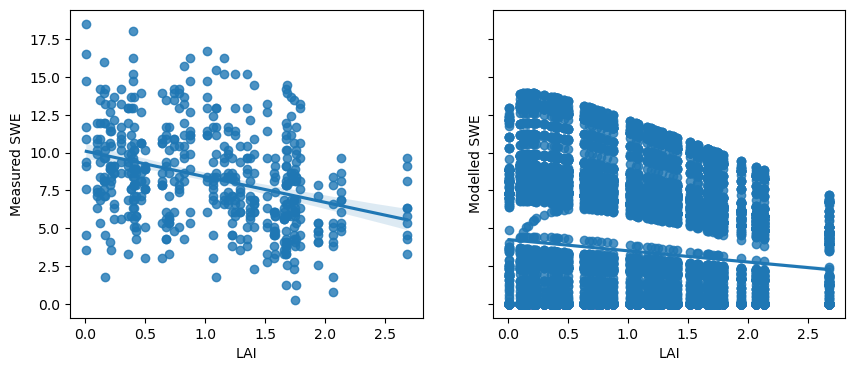

In [11]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (10,4),
    sharex = True, 
    sharey = True)

sns.regplot(modelledSnow_SWE.LAI, modelledSnow_SWE.SWE_cm_measured,
            ax = ax1)

sns.regplot(modelledSnow_SWE.LAI, modelledSnow_SWE.SWE_cm_modelled,
            ax = ax2)

ax1.set_xlabel('LAI')
ax1.set_ylabel('Measured SWE')
ax2.set_ylabel('Modelled SWE')

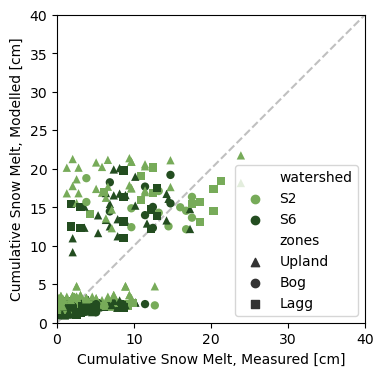

In [12]:
'''Cumulative estimated Melt'''
#Track cumulative melt
modelledSnow_SWE['Melt_cm_measured_cumsum'] = modelledSnow_SWE.groupby(['stakes'])['Melt_cm_measured'].cumsum()
modelledSnow_SWE['Melt_cm_modelled_cumsum'] = modelledSnow_SWE.groupby(['stakes'])['Melt_cm_modelled'].cumsum()

#Plot
fig, ax = plt.subplots(1, 1, figsize = (6,4))

ax.axline(xy1 = [0, 0], xy2 = [40, 40], linestyle = '--', color = 'silver', zorder = -5)
sns.scatterplot(data = modelledSnow_SWE, x = 'Melt_cm_measured_cumsum', y = 'Melt_cm_modelled_cumsum',
                hue = 'watershed', style = 'zones', 
                palette = {'S2': '#77ab59', 'S6': '#234d20'}, 
                linewidth = 0,
                markers = ['^', 'o', 's'])
ax.set_xlabel('Cumulative Snow Melt, Measured [cm]')
ax.set_ylabel('Cumulative Snow Melt, Modelled [cm]')
ax.set_xlim(0, 40)
ax.set_ylim(0, 40)
ax.set_aspect('equal')
ax.legend()



In [13]:
#Add precipitation to model csv
modelledSnow_SWE = pd.merge(precip[['Date', 'P_in']], modelledSnow_SWE, left_on = 'Date', right_on = 'Date', how = 'outer')

#Output
modelledSnow_SWE.to_csv('./Cleaned Data/snowModel_results2023.csv')